In [1]:
from pathlib import Path
%matplotlib inline
import pandas as pd
from imutils import build_montages
import numpy as np
import cv2
from tqdm.notebook import tqdm
from pprint import pprint
import os

from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
import keras.backend as K
import matplotlib.pyplot as plt

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# load/preprocess images

In [2]:
DATA_DIR = Path('./frgc32x32/')
images = [x.name for x in DATA_DIR.glob('*')]

In [3]:
paths_all_labels = []
for image in images:
    x = image.split("d", 1)
    paths_all_labels.append((x[0], './frgc32x32/'+image))

In [4]:
image_paths = list(DATA_DIR.glob('*.png'))
user_id = [x.name.split('d')[0] for x in image_paths]
user_img_id = [x.name.split('d')[1].replace('.png', '') for x in image_paths]

directory_df = pd.DataFrame({
    'user_id': user_id,
    'user_img_id': user_img_id,
    'path': [str(x) for x in image_paths]
})

In [5]:
(    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
     .describe()
)

,count
count,568.000000
mean,21.667254
std,16.794857
min,2.000000
25%,8.000000
50%,18.000000
75%,32.000000
max,70.000000


<AxesSubplot:xlabel='user_id'>

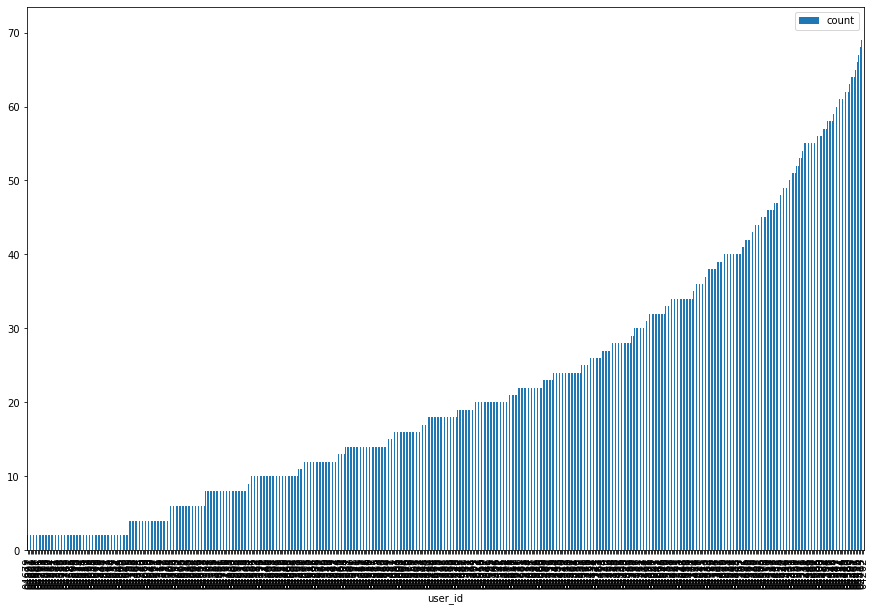

In [6]:
(
    directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [7]:
data_size = 20

ids_to_keep = ( 
    directory_df
    .groupby('user_id')['user_img_id']
    .count() >= data_size
)
ids_to_keep = ids_to_keep[ids_to_keep].index

subset_directory_df = (
    directory_df
    .loc[directory_df['user_id'].isin(ids_to_keep)]
    .sample(frac=1)
    .groupby('user_id')
    .head(data_size)
    .copy()
)

old_unique = directory_df['user_id'].nunique()
new_unique = subset_directory_df['user_id'].nunique()
print(f"There are {new_unique}/{old_unique} ({new_unique/old_unique*100:.2f}%)" +
      " unique IDs remaining.")

There are 265/568 (46.65%) unique IDs remaining.


<AxesSubplot:xlabel='user_id'>

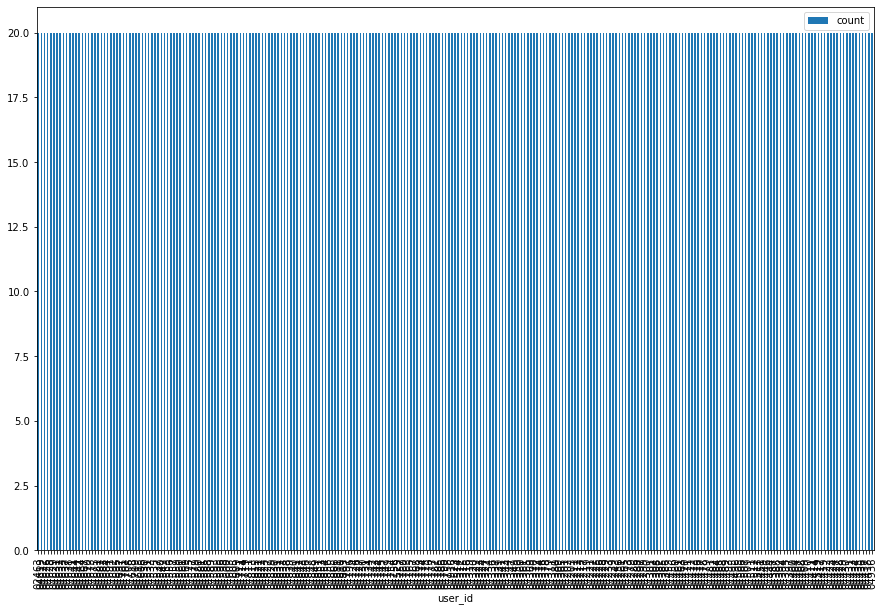

In [8]:
(
    subset_directory_df
    .groupby('user_id')['user_img_id']
    .count()
    .to_frame('count')
    .sort_values('count')
    .plot(kind='bar', figsize=(15, 10))
)

In [9]:
subset_directory_df.head()

,user_id,user_img_id,path
10939,04830,02,frgc32x32\04830d02.png
4652,04463,163,frgc32x32\04463d163.png
11743,04881,78,frgc32x32\04881d78.png
11545,04865,18,frgc32x32\04865d18.png
2188,04347,59,frgc32x32\04347d59.png


In [10]:
def load_images():
    _labels = []

    items = []
    for _, row in tqdm(subset_directory_df.iterrows(), desc='loading images'):
        img = cv2.imread(row['path'], 0)
        img = cv2.resize(img, (32, 32))
        if row['user_id'] not in _labels:
            _labels.append(row['user_id'])
        lbl = _labels.index(row['user_id'])
        items.append((img, lbl))
    return items

items = load_images()

loading images: |          | 0/? [00:00<?, ?it/s]

In [11]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    numClasses = 265

    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]

        pairImages.append([currentImage, posImage])
        pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]

        pairImages.append([currentImage, negImage])
        pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)

In [12]:
train_test_split = 0.7
split = int(train_test_split * len(items))

trainX = np.array([x[0] for x in items[:split]])
trainY = np.array([x[1] for x in items[:split]])

testX = np.array([x[0] for x in items[split:]])
testY = np.array([x[1] for x in items[split:]])

trainX = trainX / 255.0
testX = testX / 255.0

# add a channel dimension to the images
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)

(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)


# build model

In [13]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 64
EPOCHS = 100

BASE_OUTPUT = 'output'
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

def build_siamese_model(inputShape, embeddingDim=48):
    inputs = Input(inputShape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)

    model = Model(inputs, outputs)

    return model

def euclidean_distance(vectors):
	# unpack the vectors into separate lists
    (featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
	# return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def plot_training(H, plotPath):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)



In [14]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

# Compile model

In [15]:
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])

# train model

In [16]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)

Epoch 1/100
116/116 [==============================] - 5s 16ms/step - loss: 0.6920 - accuracy: 0.4967 - val_loss: 0.6895 - val_accuracy: 0.5776

# storing and plotting model

INFO:tensorflow:Assets written to: output\siamese_model\assets


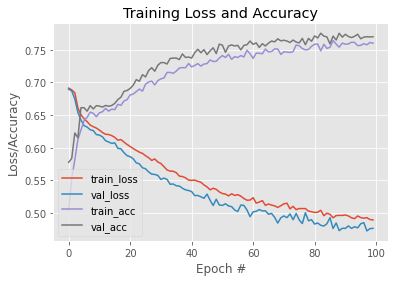

In [17]:
model.save(MODEL_PATH)
plot_training(history, PLOT_PATH)